# Goal

Datasets:
1. CIFAR-10
2. MNIST

Models:
1. Convolutional Features
2. ReLU Features
3. Fourier Features

Each model transforms the data to a feature matrix $[M_{TM} | M_{TU}]$ where $M_{TM}$ is the data matrix for the training set and $M_{TU}$ are the basis functions that we have not yet modeled. We will compute the best coefficients, $\tilde{c}$ of basis functions to model the labels on the modeled training set and the best coefficients, $c$, of all basis functions to model the labels on the whole training set. We will then compute the error $c_{err} = \tilde{c}-c^*$ where $c^*$ is the truncated version of $c$ to match the size of $\tilde{c}$. We initialize $c$ with the least-squares coefficients learned from the whole training set. Then we compute $\tilde{c}$ by solving the least-squares problem on the sampled training set.

For each dataset, we will:
- Sample the features uniformly at random vs by leverage scores.
- Plot $||A||_2$, $||M_{TM}^+||_2$, and $||\tilde{c}-c^*||_2$ for the sampled features as a function of the number of sampled points.

We expect to see that leverage score sampling leads to a smaller error $||\tilde{c}-c^*||_2$ for the same number of sampled points.


## MNIST

The MNIST dataset consists of 70,000 images of handwritten digits (0-9) in grayscale with a resolution of 28x28 pixels. This gives us a $70,000 \times 784$ data matrix.
- A Convolutional Neural network will transform the data to a $70,000 \times 200$ matrix (by removing the last layer).
- A Random ReLU fully-connected network ($y({\textbf{t}}) = \sum_{k=1}^{200} w_k \sigma(\left<\textbf{t}, {\textbf{v}}_k\right>)$ with $\sigma(x) = \max(0,x)$ and $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.
- A Fourier fully-connected network ($y({\textbf{t}}) = \mathscr{R}(\sum_{k=1}^{200} w_k \exp(i\pi\left<\textbf{t}, {\textbf{v}}_k\right>)) = \sum_{k=1}^{200} w_k \cos(\pi\left<\textbf{t}, {\textbf{v}}_k\right>) = $ with $\textbf{v}_k$ being randomly initialized weights and $w_k$ being the learned coefficients) will transform the data to a $70,000 \times 200$ matrix.

In [ ]:
import torch

from torchvision.datasets import MNIST

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", DEVICE)

mnist_X = MNIST(root="./data", train=True, download=True).data.float().to(DEVICE).reshape(-1, 1, 28, 28) / 255.0
mnist_y = MNIST(root="./data", train=True, download=True).targets.to(DEVICE)
test_mnist_X =  MNIST(root="./data", train=False, download=True).data.float().to(DEVICE).reshape(-1, 1, 28, 28) / 255.0
test_mnist_y = MNIST(root="./data", train=False, download=True).targets.to(DEVICE)


using cpu


In [41]:
# Verify CNN accuracy on MNIST

from models.mnist_cnn import MnistConvNet, BASIS_FUNCTIONS
from torch.utils.data import TensorDataset

network = MnistConvNet()
network.load_state_dict(torch.load("models/mnist_cnn.pth", map_location=DEVICE))
network.eval()


def verify_mnist_cnn(model: MnistConvNet, device):
    model.to(device)
    correct = 0
    total = 0
    test_loader = torch.utils.data.DataLoader(
        TensorDataset(test_mnist_X, test_mnist_y),
    )
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds: torch.Tensor = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
    print(f"Test accuracy: {correct / total:.4f}")


# verify_mnist_cnn(network, DEVICE)

We get an accuracy on the whole dataset of `0.9871` on the testing set. Pretty good. Now we can embed the data using the convolutional layers of the network and use that as our feature matrix for sampling.

In [7]:
import numpy as np

# Random Fourier Features
def rff_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)

    W = torch.randn(X.shape[1], features, device=X.device)

    return torch.cos(torch.pi * X @ W) / np.sqrt(features)  # Normalize


# Random ReLU Features
def relu_features(X, features=200) -> torch.Tensor:
    N, *_ = X.shape
    X = X.reshape(N, -1)
    W = torch.randn(X.shape[1], features, device=X.device)
    return torch.relu(X @ W) / np.sqrt(features)


In [4]:
# Embed the testing set (not the training set)
def embed_dataset(X, model, device):
    # Embed the data using the convolutional layers of the network
    embeddings = torch.tensor(np.zeros((X.shape[0], BASIS_FUNCTIONS,))).to(
        device
    )

    with torch.no_grad():
        for batch_start in range(0, X.shape[0], 256):
            batch_end = min(batch_start + 256, X.shape[0])
            batch = X[batch_start:batch_end].to(device)
            batch_embeddings = model.embed(batch)
            embeddings[batch_start:batch_end] = batch_embeddings
    return embeddings

In [44]:
mnist_cnn_embedding = embed_dataset(test_mnist_X, model=network, device=DEVICE)
print("mnist cnn on", mnist_cnn_embedding.device)
print(mnist_cnn_embedding.shape)

mnist_rff_features = rff_features(test_mnist_X, features=200)
print("mnist rff on", mnist_rff_features.device)
print(mnist_rff_features.shape)

mnist_relu_features = relu_features(test_mnist_X, features=200)
print("mnist relu on", mnist_relu_features.device)
print(mnist_relu_features.shape)

mnist cnn on cpu
torch.Size([10000, 200])
mnist rff on cpu
torch.Size([10000, 200])
mnist relu on cpu
torch.Size([10000, 200])


In [5]:
import torch.linalg

def parameter_error(
    data: torch.Tensor,
    labels: torch.Tensor,
    c_true: torch.Tensor,
    indices: torch.Tensor,
    lstsq_weights: torch.Tensor | None = None,
    regularize: float = 1e-6,
):
    A = data[indices, :].double()
    y = labels[indices, :].double()
    if lstsq_weights is not None:
        A *= torch.sqrt(lstsq_weights)[:, None]
        y *= torch.sqrt(lstsq_weights)[:, None]
    c_computed = torch.linalg.lstsq(
        A.T @ A + regularize * torch.eye(data.shape[1], device=data.device),
        A.T @ y,
    ).solution
    return (c_true.double() - c_computed).norm() / c_true.double().norm()


def norm_M_pinv(data: torch.Tensor, indices: torch.Tensor):
    return torch.linalg.norm(torch.linalg.pinv(data[indices, :]), ord="fro")


def simulation(
    x_axis: list[int],
    M: torch.Tensor,
    labels: torch.Tensor,
    trials: int = 10,
    regularize: float = 1e-6,
):
    device = M.device

    if torch.linalg.matrix_rank(M) < M.shape[1]:
        print(
            f"data is ill-conditioned {torch.linalg.matrix_rank(M)=} < {M.shape[1]=}, using regularization constant",
            regularize,
        )
        # Do Tikhonov/Ridge regularization
        c_true = torch.linalg.lstsq(
            M.T @ M
            + regularize * torch.eye(M.shape[1], device=M.device),
            M.T @ labels,
        ).solution
    else:
        c_true = torch.linalg.lstsq(M, labels).solution

    data = {
        metric: {method: [] for method in ["random", "leverage", "random_leverage"]}
        for metric in ["parameter_error", "norm_M_pinv"]
    }

    for n in x_axis:
        print(f"  Sampling {n} points...")
        total_p_err_random, total_err_random, total_M_pinv_random = (
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
        )
        total_p_err_levg, total_err_levg, total_M_pinv_levg = (
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
        )
        total_p_err_rand_levg, total_err_rand_levg, total_M_pinv_rand_levg = (
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
            torch.tensor(0.0, device=DEVICE),
        )

        for _ in range(trials):
            leverage_scores = (
                torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2
            )

            random_indices = torch.randperm(M.shape[0], device=device)[:n]
            random_weights = None  # Uniform weights for unweighted least squares
            top_leverage_indices = torch.topk(leverage_scores, n, largest=True).indices
            top_leverage_weights = None
            random_leverage_indices = torch.multinomial(
                leverage_scores, n, replacement=True
            )
            random_leverage_weights = BASIS_FUNCTIONS / leverage_scores[random_leverage_indices]

            for (indices, weights), (p_err_storage, aliasing_err_storage, M_pinv_norm_storage) in [
                (
                    (random_indices, random_weights),
                    (total_p_err_random, total_err_random, total_M_pinv_random),
                ),
                (
                    (top_leverage_indices, top_leverage_weights),
                    (total_p_err_levg, total_err_levg, total_M_pinv_levg),
                ),
                (
                    (random_leverage_indices, random_leverage_weights),
                    (
                        total_p_err_rand_levg,
                        total_err_rand_levg,
                        total_M_pinv_rand_levg,
                    ),
                ),
            ]:
                p_err_storage += parameter_error(
                    M, labels, c_true, indices, regularize=regularize, lstsq_weights=weights
                )
                M_pinv_norm_storage += norm_M_pinv(M, indices)

        data["parameter_error"]["random"].append(total_p_err_random / trials)
        data["norm_M_pinv"]["random"].append(total_M_pinv_random / trials)
        data["parameter_error"]["leverage"].append(total_p_err_levg / trials)
        data["norm_M_pinv"]["leverage"].append(total_M_pinv_levg / trials)
        data["parameter_error"]["random_leverage"].append(
            total_p_err_rand_levg / trials
        )
        data["norm_M_pinv"]["random_leverage"].append(total_M_pinv_rand_levg / trials)

    return x_axis, data

In [46]:
from matplotlib import pyplot as plt

labels = torch.nn.functional.one_hot(
    test_mnist_y,
    num_classes=10,
).to(DEVICE, dtype=torch.float32)

SAMPLE_POINTS = labels.shape[0]

SAMPLE_POINT_STEP = 1000
SAMPLE_POINT_LOG_STEP = 0.1

X_AXIS = [int(10 ** (SAMPLE_POINT_LOG_STEP * i)) for i in range(10, int(np.log10(SAMPLE_POINTS) / SAMPLE_POINT_LOG_STEP) + 1)]


TRIALS = 20
REGULARIZER = 1e-10

print("Simulating CNN features...")
print("-----------------------")
cnn_x_axis, cnn_data = simulation(
    X_AXIS,
    mnist_cnn_embedding.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
print("Simulating RFF features...")
print("-----------------------")
rff_x_axis, rff_data = simulation(
    X_AXIS,
    mnist_rff_features.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
print("Simulating ReLU features...")
print("-----------------------")
relu_x_axis, relu_data = simulation(
    X_AXIS,
    mnist_relu_features.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)

Simulating CNN features...
-----------------------
data is ill-conditioned torch.linalg.matrix_rank(M)=tensor(192) < M.shape[1]=200, using regularization constant 1e-10
  Sampling 10 points...
  Sampling 12 points...
  Sampling 15 points...
  Sampling 19 points...
  Sampling 25 points...
  Sampling 31 points...
  Sampling 39 points...
  Sampling 50 points...
  Sampling 63 points...
  Sampling 79 points...
  Sampling 100 points...
  Sampling 125 points...
  Sampling 158 points...
  Sampling 199 points...
  Sampling 251 points...
  Sampling 316 points...
  Sampling 398 points...
  Sampling 501 points...
  Sampling 630 points...
  Sampling 794 points...
  Sampling 1000 points...
  Sampling 1258 points...
  Sampling 1584 points...
  Sampling 1995 points...
  Sampling 2511 points...
  Sampling 3162 points...
  Sampling 3981 points...
  Sampling 5011 points...
  Sampling 6309 points...
  Sampling 7943 points...
  Sampling 10000 points...
Simulating RFF features...
-----------------------
  S

[tensor(0.9497), tensor(0.9182), tensor(1.0167), tensor(0.9471), tensor(1.1511), tensor(1.2716), tensor(1.4391), tensor(1.6708), tensor(2.0100), tensor(2.4094), tensor(3.0668), tensor(3.1918), tensor(1.8812), tensor(1.0202), tensor(2.3110), tensor(1.9942), tensor(1.8039), tensor(1.2555), tensor(2.3291), tensor(2.1992), tensor(1.4092), tensor(2.3533), tensor(1.2969), tensor(1.3558), tensor(1.5879), tensor(1.2379), tensor(2.0886), tensor(1.6684), tensor(1.6622), tensor(1.5086), tensor(1.1907)]


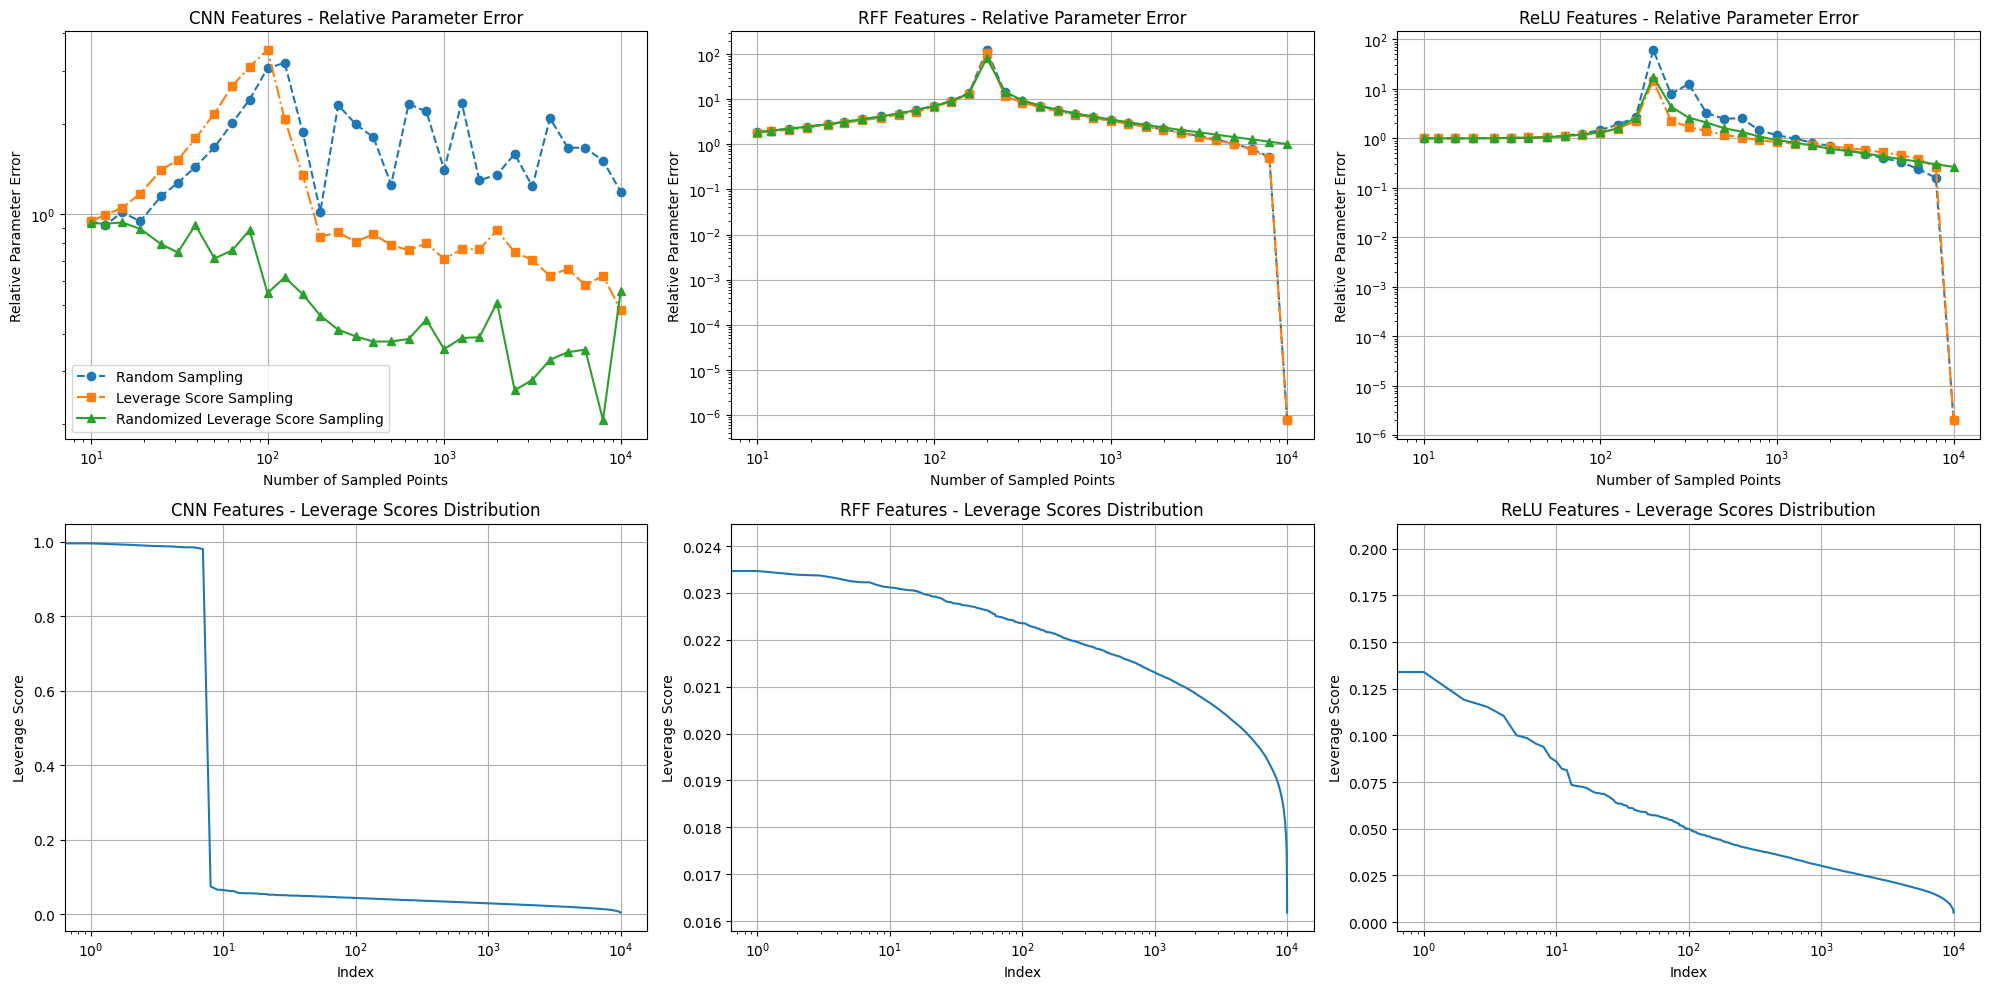

In [49]:
# Plot results in 4 by 3 grid (4 metrics, 3 datasets)
metrics = [
    "parameter_error",
    # "norm_M_pinv",
]
extra_metrics = ["Leverage Scores Distribution"]
datasets = {
    "CNN Features": (cnn_x_axis, cnn_data),
    "RFF Features": (rff_x_axis, rff_data),
    "ReLU Features": (relu_x_axis, relu_data),
}
methods = ["random", "leverage", "random_leverage"]
method_labels = {
    "random": "Random Sampling",
    "leverage": "Leverage Score Sampling",
    "random_leverage": "Randomized Leverage Score Sampling",
}
metric_labels = {
    "parameter_error": "Relative Parameter Error",
    "norm_M_pinv": "Frobenius Norm of $M_{TM}^+$",
}
method_styles = {
    "random": "o--",
    "leverage": "s-.",
    "random_leverage": "^-",
}

fig, axes = plt.subplots(
    len(metrics) + len(extra_metrics), len(datasets), figsize=(20, 5 * (len(metrics) + len(extra_metrics)))
)

print(cnn_data["parameter_error"]["random"])

for col, (dataset_name, (x_axis, data)) in enumerate(datasets.items()):
    for row, metric in enumerate(metrics):
        ax = axes[row, col]
        for method in methods:
            ax.plot(
                x_axis,
                [x.cpu().numpy() for x in data[metric][method]],
                method_styles[method],
                label=method_labels[method],
            )
        ax.set_title(f"{dataset_name} - {metric_labels[metric]}")
        ax.set_xlabel("Number of Sampled Points")
        ax.set_xscale("log")
        ax.set_ylabel(metric_labels[metric])
        ax.set_yscale("log")
        ax.grid(True)
        if row == 0 and col == 0:
            ax.legend()

    # Plot leverage scores distribution
    ax = axes[len(metrics), col]
    if dataset_name == "CNN Features":
        M = mnist_cnn_embedding.float()
    elif dataset_name == "RFF Features":
        M = mnist_rff_features.float()
    else:  # ReLU Features
        M = mnist_relu_features.float()

    leverage_scores = (
        (torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2)
        .cpu()
        .numpy()
    )
    ax.plot(np.sort(leverage_scores)[::-1])
    ax.set_title(f"{dataset_name} - Leverage Scores Distribution")
    ax.set_xlabel("Index")
    ax.set_xscale("log")
    ax.set_ylabel("Leverage Score")
    ax.grid(True)

plt.tight_layout()
plt.show()

## CIFAR-10

The CIFAR-10 dataset consists of 60,000 images in color with a resolution of 32x32 pixels, divided into 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). This gives us a 60,000 x 32 x 32 x 3 = 60,000 x 3072 data matrix.

In [1]:
import torch
from torchvision.datasets import CIFAR10

from models.cifar_cnn import CifarConvNet, BASIS_FUNCTIONS, BiggerCifarConvNet

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


test_cifar_images = (
    torch.tensor(CIFAR10(root="./data", train=False, download=True).data)
    .to(DEVICE)
    .permute(0, 3, 1, 2)
    .float()
    / 255.0
)
test_cifar_labels = torch.tensor(
    CIFAR10(root="./data", train=False, download=True).targets, device=DEVICE
)

network = CifarConvNet()
network.load_state_dict(torch.load("models/cifar_cnn.pth", map_location=DEVICE))
network.eval()

bigger_network = BiggerCifarConvNet()
bigger_network.load_state_dict(torch.load("models/cifar_bigger_cnn.pth", map_location=DEVICE))
bigger_network.eval()

def verify_cifar_cnn(model, device):
    model.to(device)
    correct = 0
    total = 0
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_cifar_images, test_cifar_labels),
        batch_size=256,
        shuffle=False,
        num_workers=2,
    )
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds: torch.Tensor = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
    print(f"  Test accuracy: {correct / total:.4f}")

print("Verifying CIFAR-10 CNN model accuracy:")
verify_cifar_cnn(network, DEVICE)
print("Verifying Bigger CIFAR-10 CNN model accuracy:")
verify_cifar_cnn(bigger_network, DEVICE)

Verifying CIFAR-10 CNN model accuracy:
  Test accuracy: 0.6935
Verifying Bigger CIFAR-10 CNN model accuracy:
  Test accuracy: 0.8976


In [9]:
cifar_cnn_embedding = embed_dataset(test_cifar_images, model=network, device=DEVICE)
print("cifar cnn on", cifar_cnn_embedding.device)
print(cifar_cnn_embedding.shape)

cifar_bigger_cnn_embedding = embed_dataset(test_cifar_images, model=bigger_network, device=DEVICE)
print("cifar bigger cnn on", cifar_bigger_cnn_embedding.device)
print(cifar_bigger_cnn_embedding.shape)

# cifar_rff_features = rff_features(test_cifar_images, features=200)
# print("cifar rff on", cifar_rff_features.device)
# print(cifar_rff_features.shape)

# cifar_relu_features = relu_features(test_cifar_images, features=200)
# print("cifar relu on", cifar_relu_features.device)
# print(cifar_relu_features.shape)

cifar cnn on cpu
torch.Size([10000, 200])
cifar bigger cnn on cpu
torch.Size([10000, 200])


In [11]:
labels = torch.nn.functional.one_hot(
    test_cifar_labels,
    num_classes=10,
).to(DEVICE, dtype=torch.float32)

SAMPLE_POINTS = labels.shape[0]

SAMPLE_POINT_STEP = 1000
SAMPLE_POINT_LOG_STEP = 0.1

X_AXIS = [int(10 ** (SAMPLE_POINT_LOG_STEP * i)) for i in range(10, int(np.log10(SAMPLE_POINTS) / SAMPLE_POINT_LOG_STEP) + 1)]


TRIALS = 50
REGULARIZER = 1e-10

print("Simulating CNN features...")
print("-----------------------")
cnn_x_axis, cnn_data = simulation(
    X_AXIS,
    cifar_cnn_embedding.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
print("Simulating Bigger CNN features...")
print("-----------------------")
bigger_cnn_x_axis, bigger_cnn_data = simulation(
    X_AXIS,
    cifar_bigger_cnn_embedding.float(),
    labels,
    trials=TRIALS,
    regularize=REGULARIZER,
)
# print("Simulating RFF features...")
# print("-----------------------")
# rff_x_axis, rff_data = simulation(
#     X_AXIS,
#     cifar_rff_features.float(),
#     labels,
#     trials=TRIALS,
#     regularize=REGULARIZER,
# )
# print("Simulating ReLU features...")
# print("-----------------------")
# relu_x_axis, relu_data = simulation(
#     X_AXIS,
#     cifar_relu_features.float(),
#     labels,
#     trials=TRIALS,
#     regularize=REGULARIZER,
# )

Simulating CNN features...
-----------------------
  Sampling 10 points...
  Sampling 12 points...
  Sampling 15 points...
  Sampling 19 points...
  Sampling 25 points...
  Sampling 31 points...
  Sampling 39 points...
  Sampling 50 points...
  Sampling 63 points...
  Sampling 79 points...
  Sampling 100 points...
  Sampling 125 points...
  Sampling 158 points...
  Sampling 199 points...
  Sampling 251 points...
  Sampling 316 points...
  Sampling 398 points...
  Sampling 501 points...
  Sampling 630 points...
  Sampling 794 points...
  Sampling 1000 points...
  Sampling 1258 points...
  Sampling 1584 points...
  Sampling 1995 points...
  Sampling 2511 points...
  Sampling 3162 points...
  Sampling 3981 points...
  Sampling 5011 points...
  Sampling 6309 points...
  Sampling 7943 points...
  Sampling 10000 points...
Simulating Bigger CNN features...
-----------------------
  Sampling 10 points...
  Sampling 12 points...
  Sampling 15 points...
  Sampling 19 points...
  Sampling 25 poin

[tensor(1.0813), tensor(1.1006), tensor(1.1384), tensor(1.1762), tensor(1.2773), tensor(1.3579), tensor(1.4925), tensor(1.6924), tensor(1.9537), tensor(2.3154), tensor(2.9178), tensor(3.8656), tensor(5.9606), tensor(62.0262), tensor(6.0967), tensor(3.9814), tensor(3.0143), tensor(2.4134), tensor(2.0050), tensor(1.6788), tensor(1.4212), tensor(1.2137), tensor(1.0464), tensor(0.8922), tensor(0.7572), tensor(0.6419), tensor(0.5339), tensor(0.4289), tensor(0.3273), tensor(0.2175), tensor(7.2415e-07)]


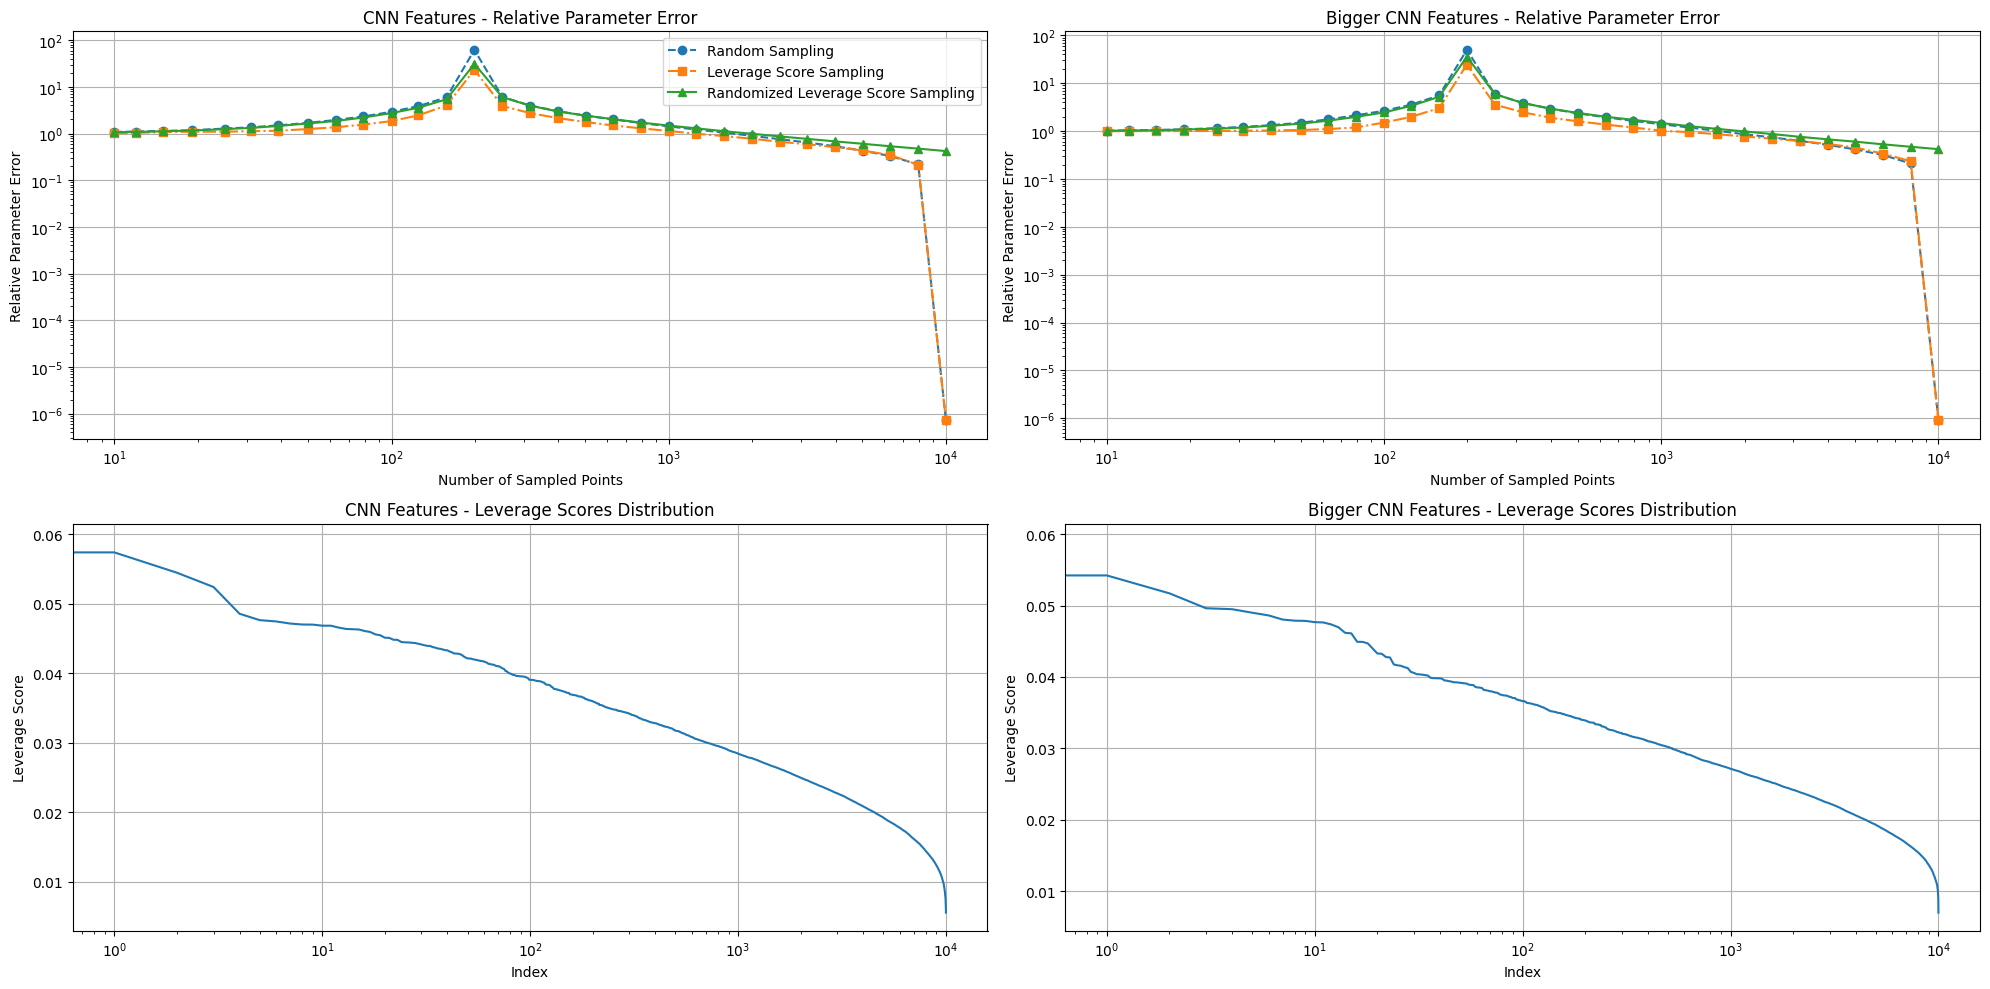

In [15]:
from matplotlib import pyplot as plt

# Plot results in 4 by 3 grid (4 metrics, 3 datasets)
metrics = [
    "parameter_error",
]
extra_metrics = ["Leverage Scores Distribution"]
datasets = {
    "CNN Features": (cnn_x_axis, cnn_data),
    "Bigger CNN Features": (bigger_cnn_x_axis, bigger_cnn_data),
    # "RFF Features": (rff_x_axis, rff_data),
    # "ReLU Features": (relu_x_axis, relu_data),
}
embeddings = {
    "CNN Features": cifar_cnn_embedding,
    "Bigger CNN Features": cifar_bigger_cnn_embedding,
    # "RFF Features": cifar_rff_features,
    # "ReLU Features": cifar_relu_features,
}
methods = ["random", "leverage", "random_leverage"]
method_labels = {
    "random": "Random Sampling",
    "leverage": "Leverage Score Sampling",
    "random_leverage": "Randomized Leverage Score Sampling",
}
metric_labels = {
    "parameter_error": "Relative Parameter Error",
    "norm_M_pinv": "Frobenius Norm of $M_{TM}^+$",
}
method_styles = {
    "random": "o--",
    "leverage": "s-.",
    "random_leverage": "^-",
}

fig, axes = plt.subplots(
    len(metrics) + len(extra_metrics), len(datasets), figsize=(20, 5 * (len(metrics) + len(extra_metrics)))
)

print(cnn_data["parameter_error"]["random"])

for col, (dataset_name, (x_axis, data)) in enumerate(datasets.items()):
    for row, metric in enumerate(metrics):
        ax = axes[row, col]
        for method in methods:
            ax.plot(
                x_axis,
                [x.cpu().numpy() for x in data[metric][method]],
                method_styles[method],
                label=method_labels[method],
            )
        ax.set_title(f"{dataset_name} - {metric_labels[metric]}")
        ax.set_xlabel("Number of Sampled Points")
        ax.set_xscale("log")
        ax.set_ylabel(metric_labels[metric])
        ax.set_yscale("log")
        ax.grid(True)
        if row == 0 and col == 0:
            ax.legend()

    # Plot leverage scores distribution
    ax = axes[len(metrics), col]
    M = embeddings[dataset_name]

    leverage_scores = (
        (torch.linalg.norm(torch.linalg.qr(M, mode="reduced").Q, dim=1) ** 2)
        .cpu()
        .numpy()
    )
    ax.plot(np.sort(leverage_scores)[::-1])
    ax.set_title(f"{dataset_name} - Leverage Scores Distribution")
    ax.set_xlabel("Index")
    ax.set_xscale("log")
    ax.set_ylabel("Leverage Score")
    ax.grid(True)

plt.tight_layout()
plt.show()